In [1]:
from __future__ import print_function
import numpy as np
import scipy as sp
import pandas as pd
import scipy.misc as spMisc
import astropy.units as u
import astropy.constants as consts
import matplotlib.pyplot as plt
import OpenGoddard.optimize as og
import poliastro as pa
import math
import poliastro.bodies as paBody

In [2]:
class System():
    def __init__(self, attractor=paBody.Sun, lref = 1*u.AU, mref = 1*u.kg):
        
        #define constants
        self.attractor = attractor
        self.mu = consts.G*attractor.mass
        
        #define non-dimensionalization parameters
        self.lref = lref.si;
        self.mref = mref.si;
        self.vref = (np.sqrt(self.mu/self.lref)).si #v of orbit around the attractor at lref distance
        self.tref = (self.lref/self.vref).si #note, this is not one year
        self.aref = ((self.vref)**2/self.lref).si
        self.thref = 1*u.rad; #angular reference
        self.omref = (self.thref/self.tref).si; #angular velocity unit (om for omega)
        self.Fref  = self.mref*self.aref;
    
    def gravity(self,pos, dimensional=True):
        """
        Returns the gravitational acceleration at a given point, in polar coordinates. 
        Currently assumes there is only one attracting body.
        
        Arg:
            Pos: [r, theta] is the position from the main attractor
            Dimensional: If true, returns astropy quantities, else returns non-dimensionalized python scalars.
            
        Returns: (a_r, a_theta) which is the radial and tangential gravitational acceleration vector. 
        
        """
        
        if dimensional== True:
            a_r = -(self.mu/(pos[0]**2)).si
            a_t = 0*(a_r.unit) #ensure they are of the same units
        else:
            a_r = -(1/(pos[0]**2))
            a_t = 0 #ensure they are of the same units
        
        return (a_r, a_t)
        
    def __str__(self):
        return 'System with attractor: {}'.format(self.attractor)

In [47]:
class Mission():
    
    def __init__(self, system):
        """
        Initializes the Mission.
        
        Args:
            system (electricTortoise/System)
        
        """
        #Requires the system to be set up first. 
        #Calls on the system properties.
        
        self.sys = system
        
        #save the non dimensionalizations
        self.nonds = (self.sys.mref, self.sys.lref, self.sys.thref, self.sys.vref, self.sys.vref)
        
        
    def spacecraft_properties(self, c = 30000*u.m/u.s, F_max = 20*u.N):
        """ 
        Function defines the key parameters of the spacecraft
        
        Args: 
            c (Astropy/Quantity): Engine exhaust speed (for example in m/s)
        """
        
        self.c = c
        self.nd_c = float(self.c/self.sys.vref)
        
        self.F_max = F_max
        self.nd_F_max = float(F_max/self.sys.Fref)
        
    #set up the problem
    def define_problem_single_phase(self, num_nodes = 20, max_iterations = 5):
        
        """
        Defines the openGoddard problem statement, assuming the entire problem is to be solved in a single phase. 
        
        Args:
            num_nodes (int): Number of computation points in time axis.
            max_iterations (int):  Maximum number of iterations.
            
            Hint. 
            More nodes allow for higher degree approximations of the solution
            More iterations allow for finer tuning of the solution towards optimal. 
            
        Returns:
            None.
        """
        
        #Define time bounds
        time_init = [0.0, self.nd_T_max]
        
        n = [num_nodes]
        max_iterations = max_iterations
        
        #hard coded the number of states
        num_states = [5]
        num_controls = [2]
        
        #define problem
        self.problem = og.Problem(time_init, n, num_states, num_controls, max_iterations)
        
        #create time vector
        self.nd_time = self.problem.time_all_section
        self.time = self.nd_time*self.sys.tref
        return
    
    def get_states(self,states=[0,1,2,3,4]):
        """ Function returns tuple of state arrays of the states indicated"""
        return tuple([self.problem.states_all_section(i) for i in states])
    
    def get_controls(self, controls=[0,1]):
        """ Function returns tuple of control arrays of the states indicated"""
        return tuple([self.problem.controls_all_section(i) for i in controls])
    
    def dynamics(self, prob, obj, section):
        
        #states must be dimensionless here. Or at least in a consistent set of units.
        
        states = self.get_states()
        controls = self.get_controls()
        
        #determine rate of change of state
        changes = self.spacecraft_dynamics(states,controls,dimensionless=True,simple_gravity=True)
        
        #store into dynamics object
        dx = og.Dynamics(prob, section)
        for i in range(len(changes)):
            dx[i] = changes[i]
            
        return dx()
    
        
    def set_max_final_time(self, T_max = 3*u.year):
        """
        Sets the maximum final time of the mission (both dimensional and non-dimensional). 
        
        Args:
            T_max (Astropy/Quantity): Final time for mission.

        Returns:
            None.
        """
        
        self.T_max = T_max
        
        #set the non-dimensionalized float
        self.nd_T_max = float(T_max/self.sys.tref)
        
        return
    
    def set_full_initial_state(self, initial_state):
        """
        Sets the initial state of the problem fully.
        Using this function explicity sets the starting state.
        
        Args:
            initial_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        self.desired_initial_state = initial_state
            
        self.m0  = initial_state[0]
        self.r0  = initial_state[1]
        self.th0 = initial_state[2]
        self.vr0 = initial_state[3]
        self.vt0 = initial_state[4]
        
        #save non-dimensional versions
        self.nd_m0  = float(self.m0 /self.sys.mref);
        self.nd_r0  = float(self.r0 /self.sys.lref);
        self.nd_th0 = float(self.th0/self.sys.thref)
        self.nd_vr0 = float(self.vr0/self.sys.vref)
        self.nd_vt0 = float(self.vt0/self.sys.vref)
        
        return
    
    def set_full_final_state(self, final_state):
        """
        Sets the final state of the problem fully.
        Using this function explicity sets the ending state.
        
        Args:
            final_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        
        self.desired_final_state = final_state
        
        self.mf  = final_state[0]
        self.rf  = final_state[1]
        self.thf = final_state[2]
        self.vrf = final_state[3]
        self.vtf = final_state[4]
        
        #save non-dimensional versions
        self.nd_mf  = float(self.mf /self.sys.mref);
        self.nd_rf  = float(self.rf /self.sys.lref);
        self.nd_thf = float(self.thf/self.sys.thref)
        self.nd_vrf = float(self.vrf/self.sys.vref)
        self.nd_vtf = float(self.vtf/self.sys.vref)
        
        return
    
    def get_time_vector(self,dimensionless=False):
        """Getter for time vector. 
        
        Args:
            dimensionless (boolean): If True, returns float array of times. If False, returns time array as Astropy/Quantity
            
        Returns:
            Time vector.
        """
        #get updated time from the problem.
        self.nd_time = self.problem.time_update()
        self.time = self.nd_time*self.sys.tref;
        
        if dimensionless == True:
            return self.nd_time
        else:
            return self.time
    
    def spacecraft_dynamics(self, state, controls = None, dimensionless = True,simple_gravity = True):
        """
            Function returns the rate of change of the state of the spacecraft. 
        """
        m  = state[0]
        r  = state[1]
        th = state[2]
        vr = state[3]
        vt = state[4]
        
        if controls is not None:
            Tr = controls[0]
            Tt = controls[1]
        else:
            Tr = np.zeros_like(m)
            Tt = np.zeros_like(m)
            
        
        T_mag = np.sqrt(Tr**2+Tt**2)
        assert all(T_mag_i>0 for T_mag_i in T_mag), "negative Thrust magnitude!"
        
        if dimensionless == True:
            mdot = -T_mag/self.nd_c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - 1 / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
        
        if dimensionless == False:
            mdot = -T_mag/self.c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - self.sys.mu / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
            
        return (mdot,rdot,thdot,vrdot,vtdot)
    
    def set_guess_function(self,state,fguess, dimensionless=False):
        """
        This method applies fguess to each time point of the prescribed state.
        Assumes fguess is applied on dimensional quantities.
        Ensure the fguess takes in a time unit, and returns a quantity of the appropriate unit, 
        for example, if it is supposed to be a length, the units are AU or m etc. 
        If it is an angle, it must be in radians or degree or similar.
        
        """
        t = self.get_time_vector(dimensionless=dimensionless)
        
        if dimensionless == False:
            if state == 'm' or state == 0:
                state  = 0
                nond   = self.sys.mref;
            elif state == 'r' or state == 1:
                state  = 1
                nond   = self.sys.lref;
            elif state == 'th' or state == 2:
                state  = 2
                nond   = self.sys.thref;
            elif state == 'vr' or state == 3:
                state  = 3
                nond   = self.sys.vref;
            elif state == 'vt' or state == 4:
                state  = 4
                nond   = self.sys.vref;
            elif state == 'Tr':
                nond   = self.sys.Fref;
                
            elif state == 'Tt':
                nond   = self.sys.Fref;
                
            guess = np.array([float(fguess(ti)/nond) for ti in t]) #is the non-dimensionalized guess for this state.
        
        else:
            guess = np.array([fguess(ti) for ti in t]) #is the non-dimensionalized guess for this state.
        
        
        if state == 'm' or state == 0:
            state  = 0
            nond   = self.sys.mref;
        elif state == 'r' or state == 1:
            state  = 1
            nond   = self.sys.lref;
        elif state == 'th' or state == 2:
            state  = 2
            nond   = self.sys.thref;
        elif state == 'vr' or state == 3:
            state  = 3
            nond   = self.sys.vref;
        elif state == 'vt' or state == 4:
            state  = 4
            nond   = self.sys.vref;
        elif state == 'Tr':
            nond   = self.sys.Fref;
            self.problem.set_controls_all_section(0,guess)
            return
        elif state == 'Tt':
            nond   = self.sys.Fref;
            self.problem.set_controls_all_section(1,guess)
            return
        
        
        self.problem.set_states_all_section(state,guess)
        
        return
    
    def set_guess_value(self,state,guess,dimensionless = False):
        """
        Function to set the initial guess of the variable.
        Args:
            state (string or int): reference of state (amongst 'm','r','th','vr','vt' or the index in that order)
            guess (numpy array): of same size as time vector, indicating the guess at each of the times. 
        """
        
        assert len(guess) == len(self.get_time_vector()) , "Length of guess doesnt match length of time vector"
        
        #non dimensionalize
        if dimensionless == False:
            if state == 'm' or state == 0:
                nond = self.sys.mref;
            elif state == 'r' or state == 1:
                nond = self.sys.lref;
            elif state == 'th' or state == 2:
                nond = self.sys.thref;
            elif state == 'vr' or state == 'vt' or state == 3 or state == 4:
                nond = self.sys.vref;
            elif state == 'Tr':
                nond = self.sys.Fref;
            elif state == 'Tt':
                nond = self.sys.Fref;
            
            guess = np.array([float(guessi/nond) for guessi in guess])
        
        #convert to index
        if state == 'm':
            state = 0
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'r':
            state = 1
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'th':
            state = 2
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'vr':
            state = 3
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'vt':
            state = 4
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'Tr':
            self.problem.set_controls_all_section(0,guess)
            return
        elif state == 'Tt':
            self.problem.set_controls_all_section(1,guess)
            return
        
        return
    
    def set_guess_value(self,state,guess,dimensionless = False):
        """
        Function to set the initial guess of the variable.
        Args:
            state (string or int): reference of state (amongst 'm','r','th','vr','vt' or the index in that order)
            guess (numpy array): of same size as time vector, indicating the guess at each of the times. 
        """
        
        assert len(guess) == len(self.get_time_vector()) , "Length of guess doesnt match length of time vector"
        
        #non dimensionalize
        if dimensionless == False:
            if state == 'm' or state == 0:
                nond = self.sys.mref;
            elif state == 'r' or state == 1:
                nond = self.sys.lref;
            elif state == 'th' or state == 2:
                nond = self.sys.thref;
            elif state == 'vr' or state == 'vt' or state == 3 or state == 4:
                nond = self.sys.vref;
            
            guess = np.array([float(guessi/nond) for guessi in guess])
        
        #convert to index
        if state == 'm':
            state = 0
        elif state == 'r':
            state = 1
        elif state == 'th':
            state = 2
        elif state == 'vr':
            state = 3
        elif state == 'vt':
            state = 4
        
        self.problem.set_states_all_section(state,guess)
        
        return
    
    def set_guess_all_states_linear(self):
        """
        Function sets the intial guess to be linear between the starting state and the final state
        """
        
        tf = float((self.get_time_vector())[-1]/self.sys.tref);
        
        # mass
        m_func = lambda t: self.nd_m0+(self.nd_mf-self.nd_m0)*(t/tf)
        self.set_guess_function('m',m_func,dimensionless=True)
        
        # r
        r_func = lambda t: self.nd_r0+(self.nd_rf-self.nd_r0)*(t/tf)
        self.set_guess_function('r',r_func,dimensionless=True)
        
        # th
        th_func = lambda t: self.nd_th0+t #in non-d space, theta dot = 1.
        self.set_guess_function('th',th_func,dimensionless=True)
        
        # vr
        #vr_func = lambda t: self.nd_vr0+(self.nd_vrf-self.nd_vr0)*(t/tf)
        vr_func = lambda t: spMisc.derivative(r_func,x0=t,n=1)
        self.set_guess_function('vr',vr_func,dimensionless=True)
        
        # vt
        vt_func = lambda t: self.nd_vt0+(self.nd_vtf-self.nd_vt0)*(t/tf)
        #thdot_func = lambda t: spMisc.derivative(th_func,x0=t,n=1)
        #vt_func = lambda t: thdot_func(t)*r_func(t)
        self.set_guess_function('vt',vt_func,dimensionless=True)
        
        Tr_func = lambda t: self.nd_F_max
        self.set_guess_function('Tr',Tr_func,dimensionless=True)
        
        Tt_func = lambda t: self.nd_F_max
        self.set_guess_function('Tt',Tt_func,dimensionless=True)
        
    def plot_all_states(self,dimensionless=True, save_dir=None):
        """
        Function plots each state.
        Args:
            dimensionless (boolean): Determines whether to plot in non-dimensional quantities or not.
            
        """
        if dimensionless == False:
            raise ValueError('dimensioned quantities not implemented yet')
            
        elif dimensionless == True:
            t = self.get_time_vector(dimensionless=True)
            states = self.get_states()
            
            for i in range(len(states)):
                plt.figure()
                plt.plot(t,states[i],'.-')
                plt.xlabel('t [-]')
                plt.ylabel(f'State {i}')
                plt.title(f'State {i}')
                plt.grid(True)
    
    
    def load_guess_from_file(self,filename='OpenGoddard_output.csv',dimensionless = True):
        
        df=pd.read_csv(filename)
        
        if dimensionless== True:
            time = mission.get_time_vector(dimensionless=True)
        
            for i in range(5):
                newGuess = np.interp(time,df["# time"],df[f" state{i}"])
                mission.problem.set_states_all_section(i,newGuess)
                
            for i in range(2):
                newGuess = np.interp(time,df["# time"],df[f" control{i}"])
                mission.problem.set_controls_all_section(i,newGuess)
              
        if dimensionless == False:
            raise ValueError('not yet implemented')
        return
    

In [153]:
sys = System(lref=1*u.AU, mref=2000*u.kg)
mission=Mission(sys)
mission.set_max_final_time(2*u.year)
mission.spacecraft_properties(c = 30000*u.m/u.s,F_max = 1*u.N)
mission.set_full_initial_state([2000*u.kg, 1*u.AU, 0*u.rad, 0*u.m/u.s, mission.sys.vref])
mission.set_full_final_state([1000*u.kg, 3*u.AU, 3*np.pi*u.rad, 0*u.m/u.s, mission.sys.vref*np.sqrt(1/3)])

In [154]:
nd_delv = 1-1/np.sqrt(3)

In [155]:
nd_delv

0.42264973081037416

In [156]:
at = (mission.F_max/mission.m0)

In [157]:
nd_at = float(at/mission.sys.aref)

In [158]:
(nd_delv/nd_at)*mission.sys.tref.to(u.year)

<Quantity 0.79781049 yr>

In [159]:
mdot = mission.F_max/mission.c

In [160]:
(mdot*(nd_delv/nd_at)*mission.sys.tref.to(u.year)).si

<Quantity 839.23280558 kg>

In [161]:
mission.c

<Quantity 30000. m / s>

In [187]:
mission.define_problem_single_phase(num_nodes = 60, max_iterations = 5)

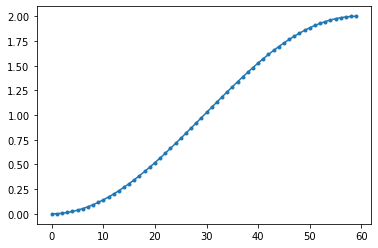

In [188]:
plt.plot(mission.get_time_vector(dimensionless=False).to(u.year),'.-')

In [189]:
mission.get_time_vector().to(u.year)

<Quantity [0.        , 0.00207301, 0.00694371, 0.01458299, 0.02496896,
           0.03807256, 0.05385726, 0.07227903, 0.09328653, 0.11682121,
           0.14281748, 0.17120286, 0.20189825, 0.2348181 , 0.26987064,
           0.30695819, 0.34597737, 0.38681942, 0.42937053, 0.47351208,
           0.51912104, 0.5660703 , 0.614229  , 0.66346292, 0.71363482,
           0.76460488, 0.81623102, 0.86836936, 0.92087458, 0.97360033,
           1.02639967, 1.07912542, 1.13163064, 1.18376898, 1.23539512,
           1.28636518, 1.33653708, 1.385771  , 1.4339297 , 1.48087896,
           1.52648792, 1.57062947, 1.61318058, 1.65402263, 1.69304181,
           1.73012936, 1.7651819 , 1.79810175, 1.82879714, 1.85718252,
           1.88317879, 1.90671347, 1.92772097, 1.94614274, 1.96192744,
           1.97503104, 1.98541701, 1.99305629, 1.99792699, 2.        ] yr>

In [190]:
mission.load_guess_from_file('OpenGoddard_output.csv')
#mission.set_guess_all_states_linear()

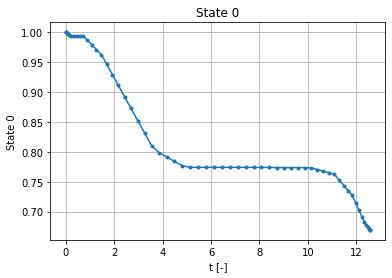

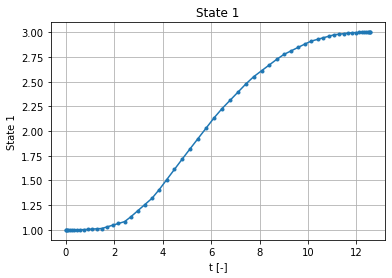

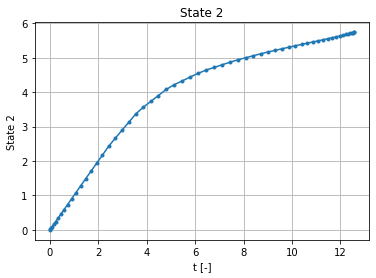

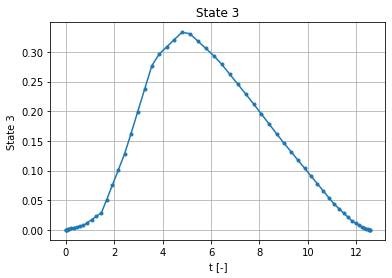

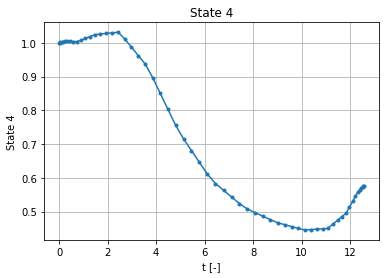

In [191]:
mission.plot_all_states()

In [192]:
def equality(prob, obj):
    m   = prob.states_all_section(0)
    r  = prob.states_all_section(1)
    th  = prob.states_all_section(2)
    vr   = prob.states_all_section(3)
    vt  = prob.states_all_section(4)
    
    Tr  = prob.controls_all_section(0)
    Tt  = prob.controls_all_section(1)

    tf  = prob.time_final(-1)

    result = og.Condition()

    # event condition
    result.equal(m[0], obj.nd_m0)
    result.equal(r[0], obj.nd_r0)
    result.equal(th[0],obj.nd_th0)
    result.equal(vr[0],obj.nd_vr0)
    result.equal(vt[0],obj.nd_vt0) #how we defined vref

    result.equal(r[-1], obj.nd_rf)
    result.equal(vr[-1], obj.nd_vrf)
    result.equal(vt[-1], obj.nd_vtf) #has to hit this tangential velocity
    
    #compute venus flyby requirement
    #vrf=vr[-1]
    #vtf=vt[-1]
    #v_c3minus = vrf**2 + (vtf-obj.v_v)**2
    #result.equal(v_c3minus, obj.v_vinf**2)

    #result.equal(tf, 1*year/obj.tref)
    #result.equal(th[-1], (369.55*tf*obj.tref/year - 59.433)*pi/180)
    
    #result.equal(th[-1],th_venus)

    return result()

In [193]:
def inequality(prob, obj):
    m   = prob.states_all_section(0)
    r   = prob.states_all_section(1)
    th  = prob.states_all_section(2)
    vr  = prob.states_all_section(3)
    vt  = prob.states_all_section(4)
    
    
    Tr = prob.controls_all_section(0)
    Tt = prob.controls_all_section(1)

    tf  = prob.time_final(-1)
    
    FmagSq = Tr**2 + Tt**2
    
    result = og.Condition()

    # lower bounds
    #result.lower_bound(r[-1], 2)
    #result.lower_bound(Tr, -obj.nd_F_max)
    #result.lower_bound(Tt, -obj.nd_F_max)
    result.lower_bound(th, 0)
    result.lower_bound(m, 0)
    result.lower_bound(r, 0.7)
    
    result.lower_bound(tf, 0.0)
    

    # upper bounds
    result.upper_bound(r, 4)
    result.upper_bound(FmagSq, obj.nd_F_max**2)
    #result.upper_bound(Tr,   +obj.nd_F_max)
    #result.upper_bound(Tt,   +obj.nd_F_max)
    
    result.upper_bound(tf, obj.nd_T_max)
    result.upper_bound(m, obj.nd_m0)
    
    result.upper_bound(np.diff(mission.get_states([0])[0]),0) #requires mass to decrease

    return result()


In [194]:
def cost(prob,obj):
    m = prob.states_all_section(0)
    return -m[-1]/m[0]

def running_cost(prob, obj):
    return 0

In [195]:
def display_func():
    m  = mission.problem.states_all_section(0)
    
    m0 = m[0]
    mf = m[-1]
    
    dv = mission.c * np.log(m0/mf)
    
    print("mf: {0:.5f}".format(mf*mission.sys.mref))
    print("dv: {0:.5f}".format(dv))
    return

In [196]:
mission.problem.dynamics = [mission.dynamics]
mission.problem.knot_states_smooth = []
mission.problem.cost = cost
mission.problem.equality = equality
mission.problem.inequality = inequality

In [197]:
mission.problem.solve(mission, display_func, ftol=1e-7)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.6862016256556848
            Iterations: 26
            Function evaluations: 11027
            Gradient evaluations: 26
Iteration limit exceeded
mf: 1372.40325 kg
dv: 11297.51338 m / s

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.6763444384455096
            Iterations: 26
            Function evaluations: 11044
            Gradient evaluations: 26
Iteration limit exceeded
mf: 1352.68888 kg
dv: 11731.58425 m / s

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.6738829900822911
            Iterations: 26
            Function evaluations: 11046
            Gradient evaluations: 26
Iteration limit exceeded
mf: 1347.76598 kg
dv: 11840.96365 m / s

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.6728075739509018
  

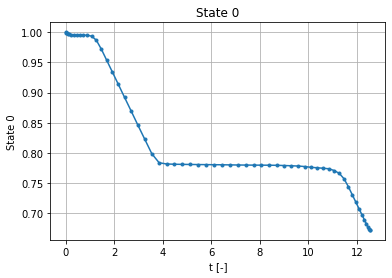

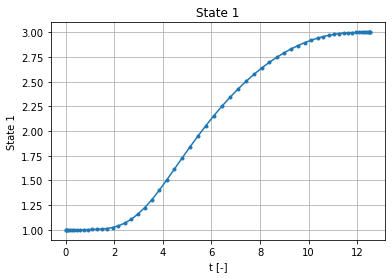

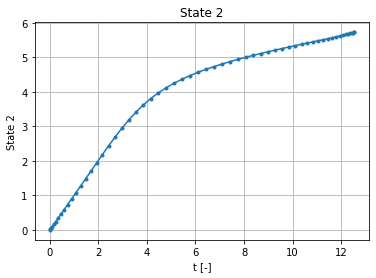

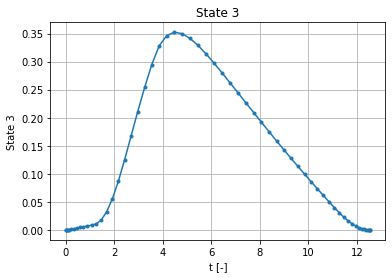

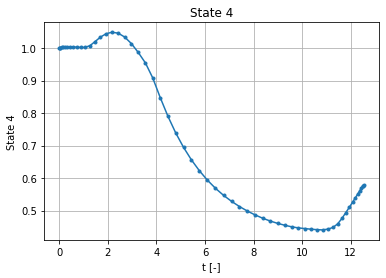

In [198]:
mission.plot_all_states()

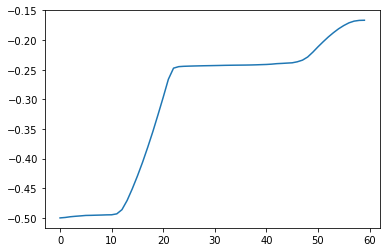

In [199]:
plt.plot(0.5*(mission.get_states([3])[0]**2 +mission.get_states([4])[0]**2) - 1/mission.get_states([1])[0])

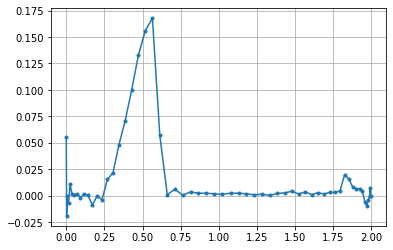

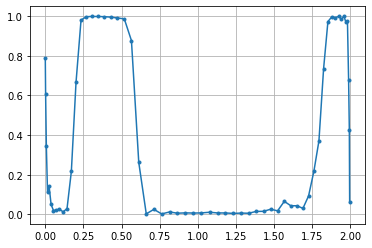

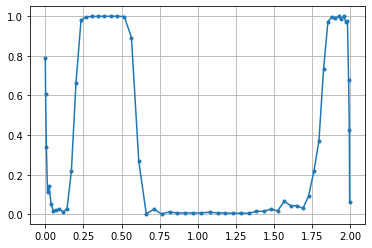

In [200]:
for i in range(2):
    plt.figure()
    plt.plot(mission.get_time_vector().to(u.year),mission.sys.Fref*mission.problem.controls_all_section(i),'.-')
    plt.grid(True)
    
plt.figure()
plt.plot(mission.get_time_vector().to(u.year),mission.sys.Fref*np.sqrt(mission.problem.controls_all_section(0)**2+mission.problem.controls_all_section(1)**2),'.-')
plt.grid(True)

In [201]:
np.diff(mission.get_states([0])[0])

array([-7.49835521e-04, -1.20382533e-03, -7.92392132e-04, -6.41856339e-04,
       -6.99919211e-04, -1.38208817e-04, -2.15003289e-04, -1.89418918e-04,
       -2.53228322e-04, -8.87061905e-05, -1.54215635e-03, -6.87617169e-03,
       -1.48280933e-02, -1.83122752e-02, -1.94347533e-02, -2.03787484e-02,
       -2.15041666e-02, -2.21800904e-02, -2.33234273e-02, -2.36305720e-02,
       -2.42763181e-02, -1.50134384e-02, -2.00947985e-03, -4.28429510e-04,
       -2.03860165e-04, -1.63579725e-04, -1.49475790e-04, -1.24871488e-04,
       -1.24322645e-04, -1.37826605e-04, -1.65864603e-04, -2.00339955e-04,
       -1.00699649e-04, -9.00319395e-05, -5.93629934e-05, -8.51490738e-05,
       -1.74999696e-04, -3.13413700e-04, -4.46796419e-04, -4.19291275e-04,
       -8.44004149e-04, -1.33442820e-03, -7.16813788e-04, -8.37474328e-04,
       -8.17096097e-04, -2.97632467e-03, -4.71383997e-03, -8.77740331e-03,
       -1.29704488e-02, -1.36104563e-02, -1.21745228e-02, -1.10580679e-02,
       -9.49846299e-03, -

In [202]:
mission.problem.controls_all_section(0)**2+mission.problem.controls_all_section(1)**2

array([4.42170019e-03, 2.63888581e-03, 8.31943679e-04, 8.74877015e-05,
       1.44350393e-04, 1.76511230e-05, 2.59131818e-06, 3.55794100e-06,
       4.95282753e-06, 1.09784327e-06, 5.88744163e-06, 3.32570748e-04,
       3.14548095e-03, 6.82607673e-03, 7.06402347e-03, 7.08542195e-03,
       7.09446836e-03, 7.10064065e-03, 7.10347231e-03, 7.09749628e-03,
       7.08323552e-03, 5.65917064e-03, 5.10163941e-04, 4.51381952e-08,
       4.71012877e-06, 3.03108177e-08, 1.09394770e-06, 2.61915332e-07,
       4.15506390e-07, 3.09171456e-07, 3.70540508e-07, 8.10090936e-07,
       3.82391912e-07, 3.52781402e-07, 1.58615321e-07, 2.84402409e-07,
       2.09163238e-07, 1.53907050e-06, 1.66663524e-06, 4.80046304e-06,
       2.21519202e-06, 3.05362612e-05, 1.32633499e-05, 1.33285589e-05,
       6.41354288e-06, 6.15023360e-05, 3.38613110e-04, 9.75247917e-04,
       3.84486533e-03, 6.72245972e-03, 7.05996467e-03, 6.98726678e-03,
       7.09631241e-03, 6.88375832e-03, 7.09645597e-03, 6.69739958e-03,
      

In [203]:
(mission.get_time_vector()).to(u.year)

<Quantity [0.        , 0.00206775, 0.00692611, 0.01454602, 0.02490567,
           0.03797606, 0.05372075, 0.07209583, 0.09305009, 0.11652512,
           0.14245549, 0.17076892, 0.20138651, 0.23422292, 0.26918662,
           0.30618016, 0.34510044, 0.38583898, 0.42828223, 0.4723119 ,
           0.51780526, 0.56463552, 0.61267216, 0.66178128, 0.71182602,
           0.76266688, 0.81416217, 0.86616836, 0.9185405 , 0.97113261,
           1.02379812, 1.07639023, 1.12876237, 1.18076856, 1.23226385,
           1.28310471, 1.33314945, 1.38225857, 1.43029521, 1.47712547,
           1.52261883, 1.5666485 , 1.60909175, 1.64983029, 1.68875057,
           1.72574411, 1.76070781, 1.79354422, 1.82416181, 1.85247524,
           1.87840561, 1.90188064, 1.9228349 , 1.94120998, 1.95695467,
           1.97002506, 1.98038471, 1.98800462, 1.99286298, 1.99493073] yr>

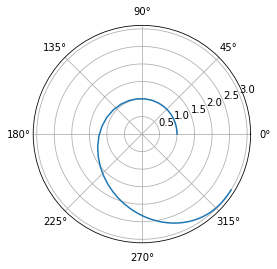

In [204]:
plt.polar(mission.get_states([2])[0],mission.get_states([1])[0])

In [205]:
mission.get_states([2])[0]

array([0.        , 0.01299696, 0.04356552, 0.09155885, 0.15684633,
       0.23927289, 0.33857857, 0.45444207, 0.58649196, 0.73429102,
       0.89729312, 1.07497271, 1.26725905, 1.47486105, 1.69798622,
       1.93510614, 2.18315199, 2.43766373, 2.69305512, 2.94346661,
       3.18357826, 3.40942982, 3.61762826, 3.8042723 , 3.96931986,
       4.11549518, 4.24552058, 4.36196025, 4.46695791, 4.56231173,
       4.64949019, 4.7296961 , 4.80391392, 4.87292401, 4.93736869,
       4.9977708 , 5.05456581, 5.10811019, 5.15871499, 5.20661984,
       5.25202483, 5.2950723 , 5.3359563 , 5.37471361, 5.41137262,
       5.44594671, 5.47855041, 5.50934281, 5.53848481, 5.56623488,
       5.59260085, 5.61731867, 5.64008141, 5.66059929, 5.67859874,
       5.69384043, 5.70611344, 5.71524762, 5.72110744, 5.72360695])

In [206]:
mission.get_states()

(array([1.        , 0.99925016, 0.99804634, 0.99725395, 0.99661209,
        0.99591217, 0.99577396, 0.99555896, 0.99536954, 0.99511631,
        0.99502761, 0.99348545, 0.98660928, 0.97178118, 0.95346891,
        0.93403416, 0.91365541, 0.89215124, 0.86997115, 0.84664772,
        0.82301715, 0.79874083, 0.78372739, 0.78171792, 0.78128949,
        0.78108563, 0.78092205, 0.78077257, 0.7806477 , 0.78052338,
        0.78038555, 0.78021968, 0.78001934, 0.77991864, 0.77982861,
        0.77976925, 0.7796841 , 0.7795091 , 0.77919569, 0.77874889,
        0.7783296 , 0.7774856 , 0.77615117, 0.77543435, 0.77459688,
        0.77377978, 0.77080346, 0.76608962, 0.75731222, 0.74434177,
        0.73073131, 0.71855679, 0.70749872, 0.69800026, 0.68971007,
        0.68301419, 0.67760347, 0.67420983, 0.67276517, 0.67246459]),
 array([1.        , 1.00000018, 1.00000117, 1.00000993, 1.00004134,
        1.00012698, 1.00030462, 1.00061716, 1.00111447, 1.00184507,
        1.00286537, 1.00421414, 1.00602227, 1.

In [207]:
mission.spacecraft_dynamics(mission.get_states(),mission.get_controls())

(array([-0.06601863, -0.05100141, -0.02863643, -0.00928636, -0.01192836,
        -0.00417117, -0.0015982 , -0.00187271, -0.00220952, -0.00104026,
        -0.00240899, -0.01810564, -0.05568207, -0.08202712, -0.08344454,
        -0.08357083, -0.08362416, -0.08366053, -0.08367721, -0.08364201,
        -0.08355794, -0.07468756, -0.02242471, -0.00021093, -0.00215471,
        -0.00017285, -0.00103841, -0.0005081 , -0.00063997, -0.00055204,
        -0.00060435, -0.00089359, -0.00061394, -0.00058969, -0.00039541,
        -0.00052947, -0.00045406, -0.00123169, -0.00128172, -0.00217527,
        -0.00147767, -0.0054863 , -0.00361575, -0.00362463, -0.00251432,
        -0.00778606, -0.01826938, -0.03100483, -0.06156196, -0.08140217,
        -0.08342056, -0.08298995, -0.08363503, -0.08237296, -0.08363588,
        -0.0812503 , -0.0817127 , -0.05682713, -0.03546011, -0.00514657]),
 array([ 0.00000000e+00,  1.77858013e-05,  7.06220443e-05,  3.00425428e-04,
         6.97521358e-04,  1.39427515e-03,  2.1

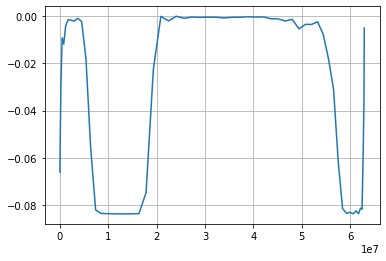

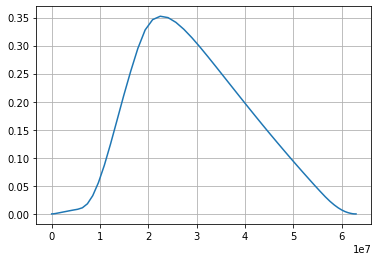

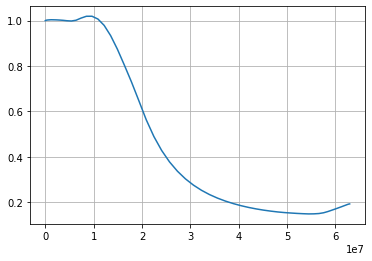

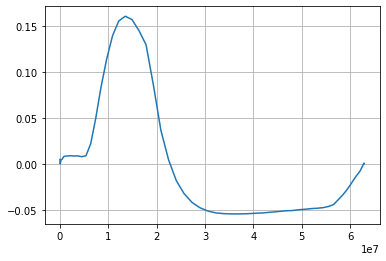

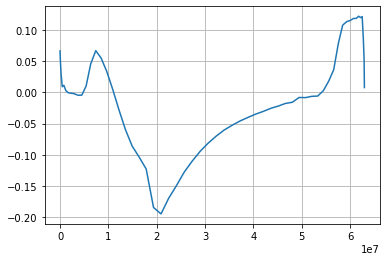

In [208]:
for i in range(5):
    plt.figure()
    plt.plot(mission.get_time_vector(),mission.spacecraft_dynamics(mission.get_states(),mission.get_controls())[i])
    plt.grid(True)

In [209]:
mission.problem.to_csv()

Completed saving "OpenGoddard_output.csv"
